## Plot for step 2:

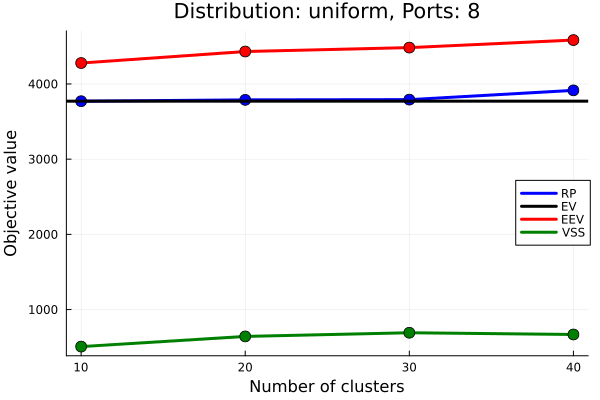

EV: Any[3771.0]
EEV: Any[4278.1965666666665, 4431.090518518334, 4483.2434450616665, 4583.4568604940005]
RP: Any[3770.560344444333, 3788.1631243563334, 3791.4801888889997, 3914.690980054666]
VSS: [507.63622222233334, 642.9273941620004, 691.7632561726668, 668.7658804393345]
VSS/EEV: [0.11865659146602872, 0.14509461981764754, 0.15429973068597252, 0.1459086232933925]


In [ ]:
using CSV, DataFrames, Plots, Statistics

#N_values = [1000, 15000, 40000, 70000]
N_values = [15000]

#distribution = ["normal", "lognormal", "uniform"]
distribution = ["uniform"]

n_cluster = [10, 20, 30, 40]
ports = [8]


for d in distribution
    for p in ports
        for nn in N_values

            EV = []
            EEV = []
            RP = []

            det_file = "../results_step_2/data_EV/data_EV_S_$(p)_$(nn)_$(d).csv"

            det = CSV.read(det_file, DataFrame)
            push!(EV, mean(det.best_objective))

            for n in n_cluster
                exp_file = "../results_step_2/data_EEV/data_EEV_S_$(p)_$(nn)_$(n)_$(d).csv"
                exp = CSV.read(exp_file, DataFrame)
                push!(EEV, mean(exp.best_objective))
                
                stoch_file = "../results_step_2/data_RP/data_RP_S_$(p)_$(nn)_$(n)_$(d).csv"
                stoch = CSV.read(stoch_file, DataFrame)
                push!(RP, mean(stoch.best_objective))
            end

            VSS = EEV .- RP
            
            println("EV: ", EV)
            println("EEV: ", EEV)
            println("RP: ", RP)
            println("VSS: ", VSS)
            println("VSS/EEV: ", VSS./EEV)
            
            plt = plot(n_cluster, RP, label="RP", lw=3, color=:blue, title="Distribution: $d, Ports: $p", xlabel="Number of clusters", ylabel="Objective value",legend=(0.95, 0.5), grid=true, xticks=10:10:50)
            scatter!(plt, n_cluster, RP, label="", ms=6, marker=:circle, color=:blue)
            hline!(plt, EV, label="EV", lw=3, color=:black)
            plot!(plt, n_cluster, EEV, label="EEV", lw=3, color=:red)
            scatter!(plt, n_cluster, EEV, label="", ms=6, marker=:circle, color=:red)
            plot!(plt, n_cluster, VSS, label="VSS", lw=3, color=:green)
            scatter!(plt, n_cluster, VSS, label="", ms=6, marker=:circle, color=:green)
            display(plt)
            #savefig(plt, "comparison_plot_S_$(d)_$(p).png")
        end
    end
end

In [ ]:
using CSV, DataFrames, Plots, Statistics

N_values = [15000, 40000, 70000]
#N_values = [15000]

distribution = ["normal", "lognormal", "uniform"]
#distribution = ["uniform"]

n_cluster = [10, 20, 30]#, 30, 40, 50]
ports = [8, 10, 15]

# DataFrame to collect all frac values
all_frac_df = DataFrame(distribution=String[], ports=Int[], N=Int[], n_cluster=Int[], frac=Union{Missing, Float64}[], VSS=Union{Missing, Float64}[])

for d in distribution
    # Set N based on distribution
    if d == "normal"
        nn = 40000
    elseif d == "lognormal"
        nn = 70000
    elseif d == "uniform"
        nn = 15000
    end
    
    for p in ports
        EV = []
        EEV = []
        RP = []
        processed_n = []

        det_file = "../results_step_2/data_EV/data_EV_S_$(p)_$(nn)_$(d).csv"
        if !isfile(det_file)
            continue
        end
        det = CSV.read(det_file, DataFrame)
        push!(EV, mean(det.best_objective))

        for n in n_cluster
            exp_file = "../results_step_2/data_EEV/data_EEV_S_$(p)_$(nn)_$(n)_$(d).csv"
            stoch_file = "../results_step_2/data_RP/data_RP_S_$(p)_$(nn)_$(n)_$(d).csv"
            if !isfile(exp_file) || !isfile(stoch_file)
                continue
            end
            exp = CSV.read(exp_file, DataFrame)
            push!(EEV, mean(exp.best_objective))
            
            stoch = CSV.read(stoch_file, DataFrame)
            push!(RP, mean(stoch.best_objective))
            
            push!(processed_n, n)
        end

        if !isempty(processed_n)
            VSS = EEV .- RP
            frac = VSS ./ EEV
            
            # Collect frac values
            for i in 1:length(processed_n)
                push!(all_frac_df, (d, p, nn, processed_n[i], frac[i], VSS[i]))
            end
        end
    end
end

# Filter out negative frac values and missing frac
all_frac_df = filter(row -> !ismissing(row.frac) && row.frac >= 0, all_frac_df)

# Encode distribution as numerical
all_frac_df.dist_code = map(d -> d == "normal" ? 1 : d == "lognormal" ? 2 : 3, all_frac_df.distribution)

# Compute correlation matrix for numerical columns
numerical_cols = [:frac, :VSS, :n_cluster, :dist_code, :ports]
numerical_df = select(all_frac_df, numerical_cols)

# Standardize the data (z-score normalization)
numerical_matrix = Matrix(numerical_df)
numerical_matrix = (numerical_matrix .- mean(numerical_matrix, dims=1)) ./ std(numerical_matrix, dims=1)

cor_matrix = cor(numerical_matrix)

println("Correlation Matrix:")
println(cor_matrix)


Correlation Matrix:
[1.0 0.9626452557279572 0.44382285874619526 0.29047734338451925 0.14620449051402082; 0.9626452557279572 1.0 0.46189039544542887 0.17193707874145556 0.3482498606509553; 0.44382285874619526 0.46189039544542887 1.0 -0.06122448979591838 -0.0684074472400819; 0.29047734338451925 0.17193707874145556 -0.06122448979591838 1.0 -0.06840744724008188; 0.14620449051402082 0.3482498606509553 -0.0684074472400819 -0.06840744724008188 1.0]


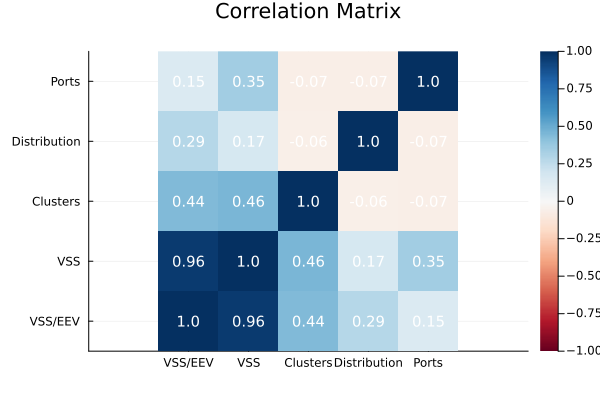

In [18]:
# Plot the correlation matrix
plt = heatmap(cor_matrix, 
              title="Correlation Matrix", 
              xticks=(1:5, ["VSS/EEV", "VSS", "Clusters", "Distribution", "Ports"]), 
              yticks=(1:5, ["VSS/EEV", "VSS", "Clusters", "Distribution", "Ports"]), 
              color=:RdBu, 
              clims=(-1,1),
              aspect_ratio=:equal)

# Add correlation values as text annotations
for i in 1:5
    for j in 1:5
        annotate!(plt, j, i, text(string(round(cor_matrix[i,j], digits=2)), :white, 10, :center))
    end
end

display(plt)
#savefig(plt, "Correlaition.png")

# Display the collected frac values
#all_frac_df

Correlation Matrix for normal:
[1.0 0.9785115456999822 0.4390507124780743 0.4517940323727007; 0.9785115456999822 1.0 0.40936173283979055 0.6176158776887637; 0.4390507124780743 0.40936173283979055 1.0 -3.3603569742232493e-18; 0.4517940323727007 0.6176158776887637 -3.3603569742232493e-18 1.0]


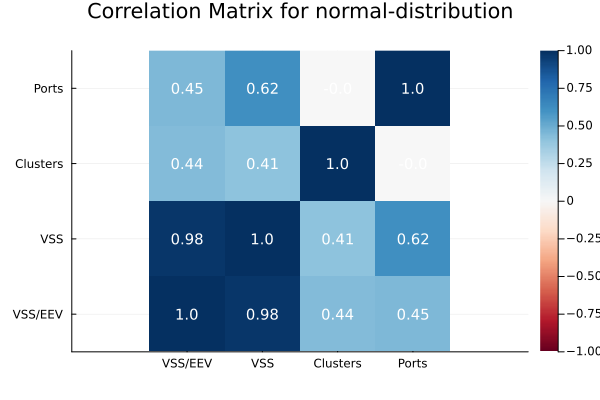

Correlation Matrix for lognormal:
[1.0 0.9806599403391006 0.5804295478252305 0.6129093231635313; 0.9806599403391006 1.0 0.5450782955075806 0.7280955524096305; 0.5804295478252305 0.5450782955075806 1.0 -3.3603569742232493e-18; 0.6129093231635313 0.7280955524096305 -3.3603569742232493e-18 1.0]


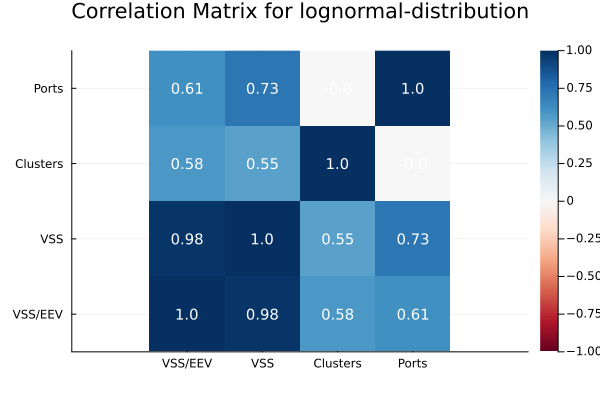

Correlation Matrix for uniform:
[1.0 0.9842838011554568 0.2847329609687408 -0.8819162738031275; 0.9842838011554568 1.0 0.4153821893594098 -0.8398223953949884; 0.2847329609687408 0.4153821893594098 1.0 1.664261343837697e-17; -0.8819162738031275 -0.8398223953949884 1.664261343837697e-17 1.0]


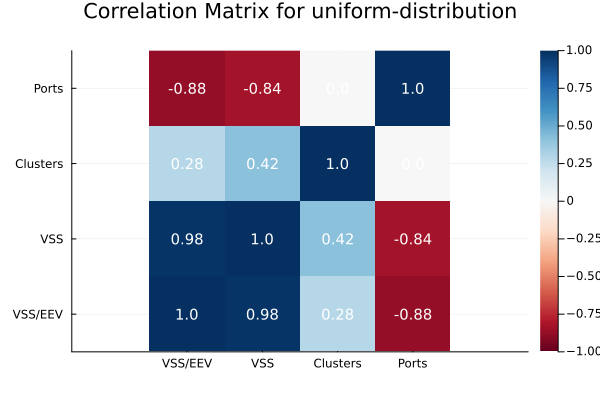

In [ ]:
# Compute correlation matrix for each distribution separately
for d in ["normal", "lognormal", "uniform"]
    df_d = filter(row -> row.distribution == d, all_frac_df)
    if d == "uniform"
        df_d = filter(row -> row.n_cluster in [10, 20], df_d)
    end
    if nrow(df_d) > 0
        numerical_cols = [:frac, :VSS, :n_cluster, :ports]  # Exclude dist_code as it's constant per distribution
        numerical_df = select(df_d, numerical_cols)
        
        # Standardize the data (z-score normalization)
        numerical_matrix = Matrix(numerical_df)
        numerical_matrix = (numerical_matrix .- mean(numerical_matrix, dims=1)) ./ std(numerical_matrix, dims=1)
        
        cor_matrix = cor(numerical_matrix)
        
        println("Correlation Matrix for $d:")
        println(cor_matrix)
        
        # Plot the correlation matrix
        plt = heatmap(cor_matrix, 
                      title="Correlation Matrix for $(d)-distribution", 
                      xticks=(1:4, ["VSS/EEV", "VSS", "Clusters", "Ports"]), 
                      yticks=(1:4, ["VSS/EEV", "VSS", "Clusters", "Ports"]), 
                      color=:RdBu, 
                      clims=(-1,1),
                      aspect_ratio=:equal)
        
        # Add correlation values as text annotations
        for i in 1:4
            for j in 1:4
                annotate!(plt, j, i, text(string(round(cor_matrix[i,j], digits=2)), :white, 10, :center))
            end
        end
        
        display(plt)
        #savefig(plt, "Correlaition_$(d).png")
    else
        println("No data for distribution $d")
    end
end

## Plot for step 1:

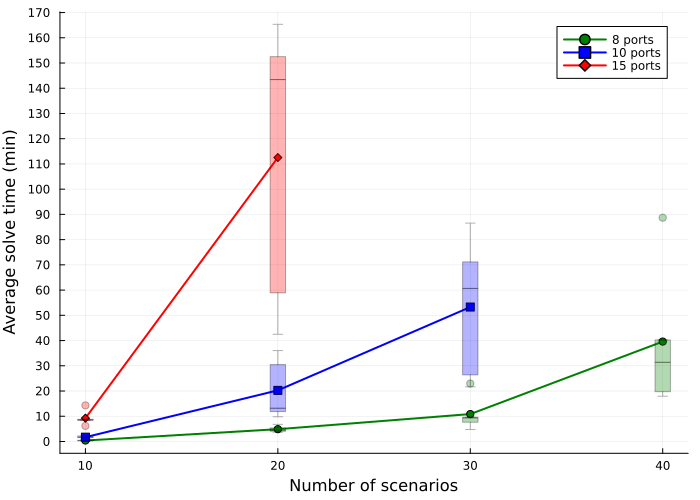

"/Users/konggullerod/Documents/Dokumenter/Skole - DTU/7. Semester/Bachelor projekt/Model/solve_times_plot_S_8_10_15.png"

In [ ]:
using Plots; gr()
using StatsPlots
using CSV
using DataFrames
using Statistics

# Configurable parameters
ports = [8, 10, 15]
n_scenarios = [10, 20, 30, 40]  # Expandable list of scenario counts

# Initialize plot
plt = plot(legend=:topright, xlabel="Number of scenarios", ylabel="Average solve time (min)", size=(700,500), grid=true, xticks=0:10:100, yticks=0:10:200)

# Colors and markers for multiple ports (expandable)
colors = [:green, :blue, :red, :orange, :purple]
markers = [:circle, :rect, :diamond, :star5, :cross]

for (i, p) in enumerate(ports)
    available_n = []
    avg_times = []
    all_times = []
    for n in n_scenarios
        fname = "../results_step_1/solve_times_S_local_$(p)_$(n).csv"
        if isfile(fname)
            data = CSV.read(fname, DataFrame)
            push!(available_n, n)
            push!(avg_times, mean(data.solve_time))
            push!(all_times, data.solve_time ./ 60)  # Store all times in minutes for boxplot
        end
    end
    # Plot the line with markers for averages
    plot!(plt, available_n, avg_times ./ 60, label="$(p) ports", color=colors[i], marker=markers[i], linewidth=2)
    # Add boxplots for the range at each scenario count
    for (j, n) in enumerate(available_n)
        boxplot!(plt, fill(n, length(all_times[j])), all_times[j], label="", color=colors[i], alpha=0.3, whisker_width=0.5)
    end
end

display(plt)
#savefig(plt, "solve_times_plot_S_$(join(ports, "_")).png")

In [ ]:
using StatsPlots
using CSV
using DataFrames
using Statistics

# Configurable parameters
ports = [8, 10, 15]
n_scenarios = [10, 20, 30, 40]  # Expandable list of scenario counts

# Colors and markers for multiple ports (expandable)
colors = [:green, :blue, :red, :orange, :purple]
markers = [:circle, :rect, :diamond, :star5, :cross]

for (i, p) in enumerate(ports)
    available_n = []
    avg_times = []
    all_times = []
    for n in n_scenarios
        fname = "../results_step_1/solve_times_S_local_$(p)_$(n).csv"
        if isfile(fname)
            data = CSV.read(fname, DataFrame)
            push!(available_n, n)
            push!(avg_times, mean(data.solve_time))
            push!(all_times, data.solve_time ./ 60)  # Store all times in minutes for boxplot
        end
    end
    # Plot the line with markers for averages
    println("$(p): ", avg_times./60)

end

8: [0.38272341728210446, 4.87659810702006, 10.862321832974752, 39.59621129353841]
10: [1.7103206626574199, 20.26942590157191, 53.279152235190075]
15: [9.24782842318217, 112.53476393620173]


In [ ]:
using CSV, DataFrames

# Assuming the seeds are the same across files
seeds = [60618579, 54337087, 70277723, 57162433, 27836244]

# Create DataFrame with scenario_seed column
df = DataFrame(scenario_seed = seeds)

# Ports and scenarios
ports = [10]
n_scenarios = [10, 20, 30]

for p in ports
    for n in n_scenarios
        fname = "../results_step_1/solve_times_S_local_$(p)_$(n).csv"
        data = CSV.read(fname, DataFrame)
        # Add column for this n, with solve times in minutes
        df[!, Symbol(string(n))] = data.solve_time ./ 60
    end
end

# Display the table
df

## Plot of variable and constraint amounts:

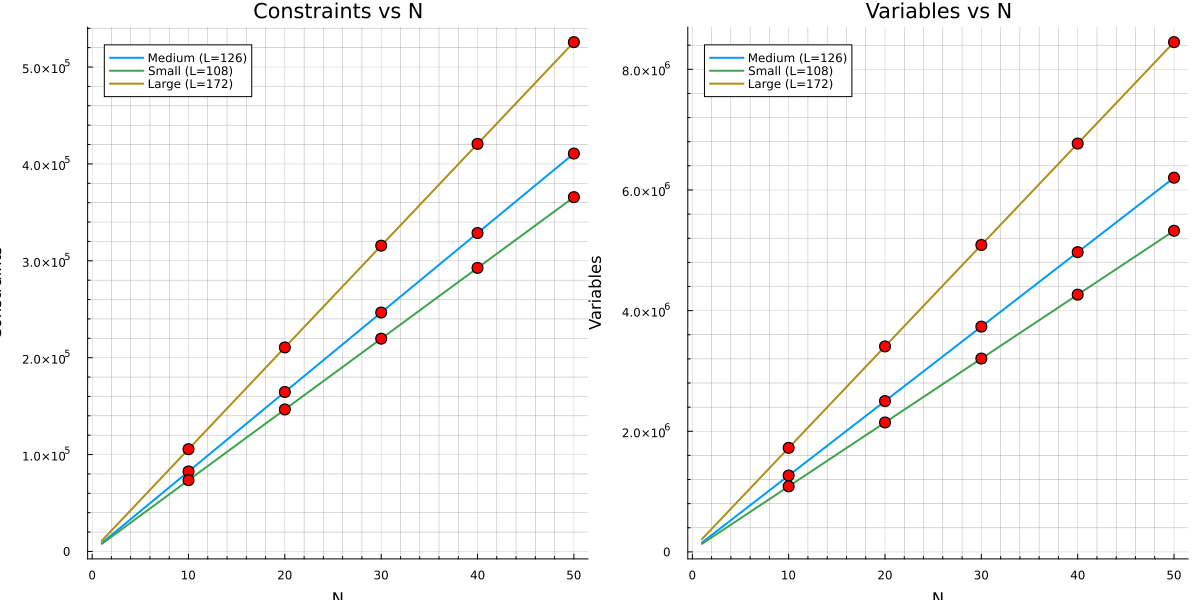

In [1]:
using Plots

P = 10
T = 28
R = (P * (P - 1)) / 2
Rp_minus_1 = R - P - 1

N_range = 1:50
N_points = [10, 20, 30, 40, 50]
ship_sizes = Dict("Small" => 108, "Medium" => 126, "Large" => 172)

# Plot constraints
p1 = plot(title="Constraints vs N", xlabel="N", ylabel="Constraints", grid=true, gridalpha=0.2, minorgrid=true, minorgridalpha=0.3)
for (name, L) in ship_sizes
    cons_vals = [5 * P * L * n + 2 * T * Rp_minus_1 * n + 2 * T * (P - 1) for n in N_range]
    plot!(p1, N_range, cons_vals, label="$name (L=$L)", linewidth=2)
    
    # Add points at specific N
    points_cons = [5 * P * L * n + 2 * T * Rp_minus_1 * n + 2 * T * (P - 1) for n in N_points]
    scatter!(p1, N_points, points_cons, label="", markersize=6, markercolor=:red)
end

# Plot variables
p2 = plot(title="Variables vs N", xlabel="N", ylabel="Variables", grid=true, gridalpha=0.2, minorgrid=true, minorgridalpha=0.3)
for (name, L) in ship_sizes
    var_vals = [n * T * Rp_minus_1 * L + 2 * n * P * L + n * T * Rp_minus_1 + T * (P - 1) * L + T * (P - 1) for n in N_range]
    plot!(p2, N_range, var_vals, label="$name (L=$L)", linewidth=2)
    
    # Add points at specific N
    points_var = [n * T * Rp_minus_1 * L + 2 * n * P * L + n * T * Rp_minus_1 + T * (P - 1) * L + T * (P - 1) for n in N_points]
    scatter!(p2, N_points, points_var, label="", markersize=6, markercolor=:red)
end

# Combine plots
plot(p1, p2, layout=(1,2), size=(1200,600))

In [2]:
L = 108
P = 15
N = 10
T = 28
R = (P*(P-1))/2

constraints = 5*P*L*N + 2*T*(R-P-1)*N + 2*T*(P-1)
variables = N*T*(R-P-1)*L + 2*N*P*L + N*T*(R-P-1) + T*(P-1)*L + T*(P-1)

println("Constraints: ", constraints)
println("variables:   ", variables)

P = 10
N = 20
R = (P*(P-1))/2
constraints = 5*P*L*N + 2*T*(R-P-1)*N + 2*T*(P-1)
variables = N*T*(R-P-1)*L + 2*N*P*L + N*T*(R-P-1) + T*(P-1)*L + T*(P-1)
println("Constraints: ", constraints)
println("variables:   ", variables)

P = 8
N = 30
R = (P*(P-1))/2
constraints = 5*P*L*N + 2*T*(R-P-1)*N + 2*T*(P-1)
variables = N*T*(R-P-1)*L + 2*N*P*L + N*T*(R-P-1) + T*(P-1)*L + T*(P-1)
println("Constraints: ", constraints)
println("variables:   ", variables)

Constraints: 131624.0
variables:   2.791408e6
Constraints: 146584.0
variables:   2.146028e6
Constraints: 161912.0
variables:   1.812844e6


In [4]:
L = 108
P = 15
N = 10
T = 28
R = (P*(P-1))/2

constraints = 5*P*L + 2*T*R
variables = R*T*L + 2*P*L + T*R
println("Constraints: ", constraints)
println("variables:   ", variables)

P = 10
N = 20
R = (P*(P-1))/2
constraints = 5*P*L + 2*T*R
variables = R*T*L + 2*P*L + T*R
println("Constraints: ", constraints)
println("variables:   ", variables)

P = 8
N = 30
R = (P*(P-1))/2
constraints = 5*P*L + 2*T*R
variables = R*T*L + 2*P*L + T*R
println("Constraints: ", constraints)
println("variables:   ", variables)

Constraints: 13980.0
variables:   323700.0
Constraints: 7920.0
variables:   139500.0
Constraints: 5888.0
variables:   87184.0


## Calculate scenario amount to represent distributions

In [ ]:
using Distributions

function required_samples(mu, sigma; accuracy=0.01, confidence=0.95)
    z = quantile(Normal(), (1 + confidence)/2)
    delta = accuracy * mu                 # relative half-width
    n = (z * sigma / delta)^2
    return ceil(Int, n)
end

#Uniform
function samples_uniform(a, b; accuracy=0.01, confidence=0.95)
    mu = (a + b) / 2
    sigma = (b - a) / sqrt(12)
    return required_samples(mu, sigma; accuracy, confidence)
end

#Normal
function samples_normal(mu, sigma; accuracy=0.01, confidence=0.95)
    return required_samples(mu, sigma; accuracy, confidence)
end

#Lognormal
function samples_lognormal(muY, sigmaY; accuracy=0.01, confidence=0.95)
    # mean and variance of lognormal
    muX = exp(muY + sigmaY^2 / 2)
    varX = (exp(sigmaY^2) - 1) * exp(2*muY + sigmaY^2)
    sigmaX = sqrt(varX)
    return required_samples(muX, sigmaX; accuracy, confidence)
end


println("Uniform(0, 1):            ", samples_uniform(0, 1))
println("Normal(mu=1, sigma=0.2):  ", samples_normal(1, 1))
println("Lognormal N(0,1):         ", samples_lognormal(1, 1))